### 1. Libraries

In [1]:
import cv2
import numpy as np
import tifffile
import zarr
import matplotlib.pyplot as plt
import json
import math
import os

from colour_lib.palette_parser import (
    ImageProcessing,
    ImageAlignment,
    ObjectDetection,
    ObjectColor,
)

img_processor = ImageProcessing.ImageProcessing()
img_aligner = ImageAlignment.ImageAlignment()
obj_detector = ObjectDetection.ObjectDetection()
obj_color_extractor = ObjectColor.ObjectColor()

![Alt text](image.png)

### 2. Downloading

Select file

In [2]:
scanner_type = 'polaris'
filepath = "/uftp/src/palettes/Calib_Polaris_Scan3.qptiff"
filename = os.path.basename(filepath)
large_lyr_number = 4

In [18]:
scanner_type = 'huron'
filepath = "/uftp/src/palettes/Calib_R1_10_10_10_202402.tif"
filename = os.path.basename(filepath)
large_lyr_number = 2

In [34]:
scanner_type = 'huron'
filepath = "/uftp/src/palettes/HEjul23_020723.ome.tiff"
filename = os.path.basename(filepath)
large_lyr_number = 2

In [50]:
scanner_type = 'huron'
filepath = "/uftp/src/palettes/IHCjul23_020723_2.ome.tiff"
filename = os.path.basename(filepath)
large_lyr_number = 2

Downloading..

In [51]:
# zarr storage
tiff_storage = tifffile.imread(
    filepath, aszarr=True
)
zarr_storage = zarr.open(tiff_storage, mode="r")

# small zarr layer
zarr_small_lyr = zarr_storage[len(zarr_storage) - 2]
zarr_small_lyr = np.array(zarr_small_lyr)
h, w = zarr_small_lyr.shape[:2]

# large zarr layer
zarr_large_lyr = zarr_storage[large_lyr_number]

In [52]:
if scanner_type == 'polaris':
    image = zarr_small_lyr
    bordered_image = img_processor.add_bottom_border(image, img_processor.get_brightest_color(image), border_size=20)
    contrast_image = img_processor.increase_contrast(bordered_image, alpha=2, beta=0)
    zarr_small_lyr_contrasted = contrast_image 
else:
    zarr_small_lyr_contrasted = zarr_small_lyr

### 3. zarr small lyr

##### Image processing

In [53]:
# Initial control
# can we detect any object on the image? lets try on rectangles. its helps to decide if we need to sharp the image.
image = zarr_small_lyr_contrasted.copy()
image_processed = img_processor.gray_thresh(image=image, scanner_type=scanner_type)
rect_coordinates, rect_image_to_show = obj_detector.find_rectangles(
    image_to_find=image_processed, show_image=True, image_to_show=zarr_small_lyr
)

In [54]:
# Alignment control
# Then we need to check if image should be fliped or rotated
flipped_image = img_aligner.flip(image_to_flip=zarr_small_lyr_contrasted, pattern=rect_coordinates)
rotated_image, rot_image_to_show = img_aligner.rotate(
    image_to_rotate=flipped_image, show_image=True, image_to_show=flipped_image
)
zarr_small_lyr_aligned = rotated_image

In [55]:
img_aligner.position

{'flip_horizontal': True,
 'flip_vertical': False,
 'flip_over': False,
 'rotation_angle': -0.05555774536722424}

##### Object detection

In [56]:
# Now we have aligned odl and can detect rectangles...
image = zarr_small_lyr_aligned
image_processed = img_processor.gray_thresh(image=image, scanner_type=scanner_type)
rect_coordinates, _ = obj_detector.find_rectangles(
    image_to_find=image_processed, show_image=True, image_to_show=image
)

In [57]:
# ... and circles inside the rectangles 
circ_coordinates = {}
rect_coordinates_with_circles = [key for key in rect_coordinates if ("CA" not in key and "dark" not in key)]

for rect_name in rect_coordinates_with_circles:

    coords = rect_coordinates[rect_name]
    crop = np.array(zarr_small_lyr_aligned)[
        coords["y0"] : coords["y1"], coords["x0"] : coords["x1"]
    ]

    crop_sobel = img_processor.sobel(image=crop)
    crop_clahe = img_processor.clahe(crop_sobel)
    crop_clahe = img_processor.clahe(crop_clahe) # Polaris
    crop_clahe = img_processor.clahe(crop_clahe) 
    crop_clahe = img_processor.clahe(crop_clahe) # Hold
    #crop_clahe = img_processor.clahe(crop_clahe) # Hnew
    crop_general = img_processor.gray_blur_canny(crop_clahe)

    if scanner_type == 'polaris':
        kernel = np.ones((9,9), np.uint8)
        crop_dilated = cv2.dilate(crop_general, kernel, iterations=1)
    else:
        crop_dilated = crop_general

    if scanner_type == 'polaris':
        tolerance_ = 0.3
    else:
        tolerance_ = 0.2
    
    crop_circ_coordinates = obj_detector.find_circles(
        crop_dilated, averaging_threshold=10, tolerance=tolerance_ 
    )
    crop_circ_coordinates = obj_detector.circles_coordinates_as_dictionary(
        crop_circ_coordinates, rect_name=rect_name[4:]
    )

    for key, value in crop_circ_coordinates.items():
        if "x_centroid" in value:
            value["x_centroid"] += coords["x0"]
            value["y_centroid"] += coords["y0"]

    circ_coordinates.update(crop_circ_coordinates)

if scanner_type == 'polaris':
    circ_coordinates.pop('A1_500')

rect_1000
rect_750
rect_500


In [58]:
# lets retrieve coordinates for non-aligned zarr_small_layer
rect_coordinates_small_lyr = img_aligner.give_original_coordinates(
    rect_coordinates, w=w, h=h, type="rectangle"
)
circ_coordinates_small_lyr = img_aligner.give_original_coordinates(
    circ_coordinates, w=w, h=h, type="circle"
)

Flip horizontal
Rotation angle: 0.05555774536722424
Flip horizontal
Rotation angle: 0.05555774536722424


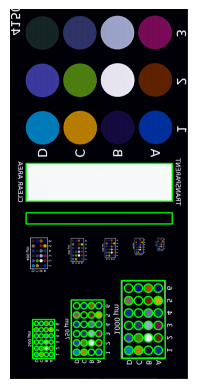

In [59]:
# ... and show them
image = zarr_small_lyr.copy()
obj_detector.draw_rectangles(image, rect_coordinates_small_lyr)
obj_detector.draw_circles(image, circ_coordinates_small_lyr)

#plt.imsave(f'images/{filename}_detected_objects.png', image)

plt.imshow(image)
plt.axis("off")
plt.show()

In [64]:
obj_coordinates_small_lyr = {**rect_coordinates_small_lyr, **circ_coordinates_small_lyr}

### 4. zarr large lyr

In [65]:
# lets scale coordinates for this lyr
obj_coordinates_large_lyr = obj_detector.scale(
    zarr_large_lyr, zarr_small_lyr, obj_coordinates_small_lyr
)

In [66]:
# ... and find mean rgb value for all objects
obj_rgb = obj_color_extractor.calculate_rgb(obj_coordinates_large_lyr, zarr_large_lyr)


A6_1000
B6_1000
C6_1000
D6_1000
A5_1000
B5_1000
C5_1000
D5_1000
A4_1000
B4_1000
C4_1000
D4_1000
A3_1000
B3_1000
C3_1000
D3_1000
A2_1000
B2_1000
C2_1000
D2_1000
A1_1000
B1_1000
C1_1000
D1_1000
rect_CA
rect_dark


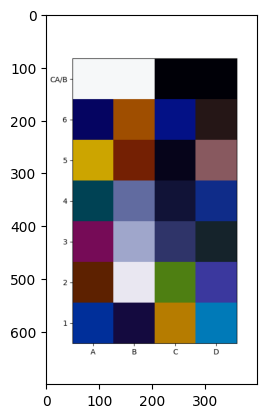

In [67]:
palette = obj_color_extractor.plot_palette(obj_rgb)
plt.imshow(palette)
plt.imsave(f'images/{filename}_palette.png', palette)

### 5. Appendix

In [68]:
# to save coordinates and rgb
with open(f"palette_obj_rgb/{filename}_{large_lyr_number}lyr.json", "w") as json_file:
    json.dump(obj_rgb, json_file)
with open(
    f"palette_obj_coordinates/{filename}_{large_lyr_number}lyr.json", "w"
) as json_file:
    json.dump(obj_coordinates_large_lyr, json_file)

In [24]:
# to download them
'''
with open(f"palette_obj_rgb/{filename}_{large_lyr_number}lyr.json", "r") as json_file:
    obj_rgb = json.load(json_file)
with open(
    f"palette_obj_coordinates/{filename}_{large_lyr_number}lyr.json", "r"
) as json_file:
    obj_coordinates_large_lyr = json.load(json_file)
'''